# Fit Some Classification Models

In [1]:
%matplotlib inline

In [2]:
import utils
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import numpy as np

# from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import precision_recall_curve

/Users/volkerh/miniconda3/envs/onco/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# plt.style.use(['dark_background', 'presentation'])
plt.style.use(['ggplot'])

In [4]:
# We don't care about this warning here...
# /Users/volkerh/miniconda3/envs/onco/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
#   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
# https://docs.python.org/3/library/warnings.html#temporarily-suppressing-warnings

import warnings
warnings.simplefilter("ignore")

# Load Stuff

In [5]:
df_01 = utils.load_and_preprocess(onehot=True, rescale_features=True, rescale_target=True, drop_oneof_onehot=False, drop_X4=False)
df_02 = utils.load_and_preprocess(onehot=True, rescale_features=True, rescale_target=True, drop_oneof_onehot=True, drop_X4=False)
df_03 = utils.load_and_preprocess(onehot=True, rescale_features=True, rescale_target=True, drop_oneof_onehot=False, drop_X4=True)

In [6]:
X_01, y_01 = utils.df_to_Xy(df_01, to_class=True)
X_02, y_02 = utils.df_to_Xy(df_02, to_class=True)
X_03, y_03 = utils.df_to_Xy(df_03, to_class=True)

# Run Models

In [7]:
clf_01 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf_02 = SVC(probability=True)
clf_03 = LogisticRegression()

# models = [ clf_01, clf_02, clf_03, clf_04 ]
models = [ clf_01, clf_02, clf_03 ]

In [8]:
scores_01 = []
for clf in models:
    scores = cross_val_score(clf, X_01, y_01, scoring='average_precision', cv=5)
    scores_01.append(scores)

In [9]:
scores_02 = []
for clf in models:
    scores = cross_val_score(clf, X_02, y_02, scoring='average_precision', cv=5)
    scores_02.append(scores)

In [10]:
scores_03 = []
for clf in models:
    scores = cross_val_score(clf, X_03, y_03, scoring='average_precision', cv=5)
    scores_03.append(scores)

# Compare Models

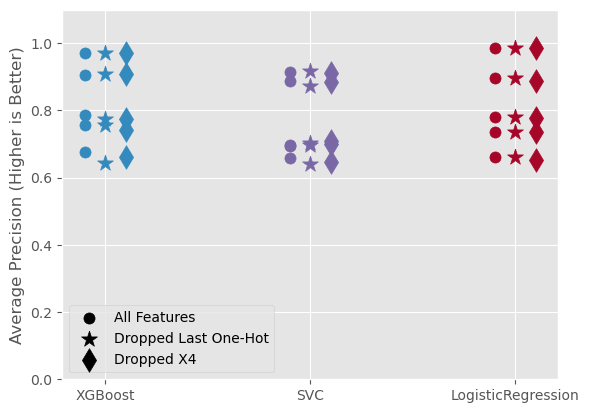

In [11]:
fig, ax = plt.subplots(1,1)

# cc = [ 'tab:blue', 'tab:orange', 'tab:green' ]
cc = ['#348ABD', '#7A68A6', '#A60628']

for kk in range(len(models)):
    ax.scatter((np.zeros_like(scores_01[kk])+kk)-0.1, scores_01[kk], c=cc[kk], marker='o', s=8**2, label='All Features')
    ax.scatter((np.zeros_like(scores_02[kk])+kk), scores_02[kk], c=cc[kk], marker='*', s=12**2, label='Dropped One One-Hot')
    ax.scatter((np.zeros_like(scores_03[kk])+kk)+0.1, scores_03[kk], c=cc[kk], marker='d', s=12**2, label='No X4')
    
# legend
h1 = ax.scatter([],[], c='k', marker='o', s=8**2, label='All Features')
h2 = ax.scatter([],[], c='k', marker='*', s=12**2, label='Dropped Last One-Hot')
h3 = ax.scatter([],[], c='k', marker='d', s=12**2, label='Dropped X4')
ax.legend([h1, h2, h3],['All Features', 'Dropped Last One-Hot', 'Dropped X4'], loc='lower left')

ax.set_xticks([0,1,2])
ax.set_xticklabels(['XGBoost', 'SVC', 'LogisticRegression'])
ax.set_ylim([0,1.1])
ax.set_ylabel('Average Precision (Higher is Better)')

pass

# Plot Examples

In [12]:
y_pred_01 = cross_val_predict(clf_01, X_01, y_01, method='predict_proba', cv=5)
y_pred_02 = cross_val_predict(clf_02, X_01, y_01, method='predict_proba', cv=5)
y_pred_03 = cross_val_predict(clf_03, X_01, y_01, method='predict_proba', cv=5)

In [13]:
p_01, r_01, _ = precision_recall_curve(y_01, y_pred_01[:,1])
p_02, r_02, _ = precision_recall_curve(y_01, y_pred_02[:,1])
p_03, r_03, _ = precision_recall_curve(y_01, y_pred_03[:,1])

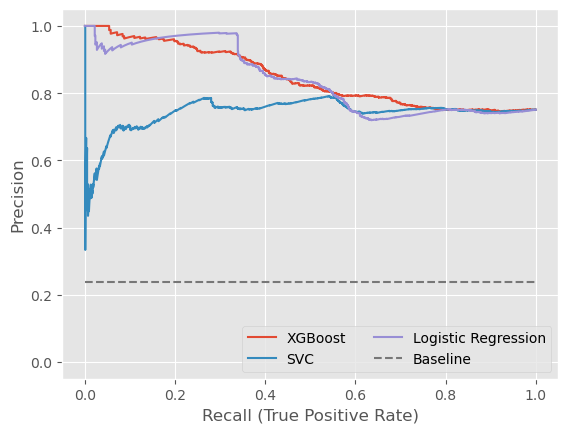

In [14]:
fig, ax = plt.subplots(1,1)

ax.plot(r_01, p_01, label='XGBoost')
ax.plot(r_02[1:], p_02[1:], label='SVC')
ax.plot(r_03, p_03, label='Logistic Regression')

ax.plot([0,1], np.ones(2) * np.sum(df_01.Y==True)/df_01.shape[0], '--', label='Baseline')

ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])
ax.set_xlabel('Recall (True Positive Rate)')
ax.set_ylabel('Precision')

ax.legend(loc='lower right', ncols=2)